## Compliance Radar Machine Learning Project

### Project Overview

This project analyzes org_compliance_data.db — an organizational dataset containing department-level operational metrics, reporting frequency, financial indicators, audit results, and anonymized engagement scores — to detect signals of potential non-compliance and provide evidence-based recommendations for risk mitigation. The work emphasizes both predictive modeling and interpretable, ethically grounded insights so that findings can inform operational policy and governance.

##### Necessary Imports

In [1]:
# Neccessary imports to load the database and for data manipulation
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import os


#### Folder Paths

In [2]:
processed_data_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\processed\\'
raw_data_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\raw\\'
images_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\images\\'
reports_path = 'C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\reports\\'

### Loading Data from the Database

In [3]:
# Creating a cursor to connect to the SQLite database
conn = sqlite3.connect('C:\\Users\\Cesar Dushimimana\\Documents\\Compliance-Radar-ML\\data\\raw\\org_compliance_data.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)



Tables in the database: [('departments',), ('risk_summary_by_division',), ('high_risk_departments',), ('data_dictionary',)]


### Saving DB tables as CSV files for backup

In [4]:
# Reading each of the tables into pandas dataframes
departments_df = pd.read_sql_query("SELECT * FROM departments", conn)
risk_by_division_df = pd.read_sql_query("SELECT * FROM risk_summary_by_division", conn)
high_risk_departments_df = pd.read_sql_query("SELECT * FROM high_risk_departments", conn)
data_dictionary_df = pd.read_sql_query("SELECT * FROM data_dictionary", conn)

# Saving the dataframes as CSV files for easier access 
departments_df.to_csv(raw_data_path + 'departments.csv', index=False)
risk_by_division_df.to_csv(raw_data_path + 'risk_summary_by_division.csv', index=False)
high_risk_departments_df.to_csv(raw_data_path + 'high_risk_departments.csv', index=False)
data_dictionary_df.to_csv(raw_data_path + 'data_dictionary.csv', index=False)
# Closing the database connection
conn.close()


### Shape of Each DB Table After Pandas DataFrame Loading

In [5]:
# Print number of rows and columns in each dataframe
print("Departments DataFrame shape:", departments_df.shape)
print("Risk by Division DataFrame shape:", risk_by_division_df.shape)
print("High Risk Departments DataFrame shape:", high_risk_departments_df.shape)
print("Data Dictionary DataFrame shape:", data_dictionary_df.shape)


Departments DataFrame shape: (709, 37)
Risk by Division DataFrame shape: (2, 8)
High Risk Departments DataFrame shape: (201, 37)
Data Dictionary DataFrame shape: (39, 4)


### Exploring Datasets

#### 1. Exploring departments dataset

In [6]:
# Describe numeric columns in departments_df
print(departments_df.describe())


       dept_age_years  manager_experience_level  supervisor_experience_level  \
count      411.000000                413.000000                   409.000000   
mean         6.802920                  2.624697                     2.398533   
std          1.915939                  1.164637                     1.137635   
min          2.000000                  0.000000                     0.000000   
25%          6.000000                  2.000000                     2.000000   
50%          7.000000                  3.000000                     2.000000   
75%          8.000000                  4.000000                     3.000000   
max         15.000000                  4.000000                     4.000000   

       reporting_lag_days  training_hours_quarterly  violations_past_3years  \
count          412.000000                409.000000              406.000000   
mean             1.682039                 43.180929                0.435961   
std              1.019693                 

In [7]:
# Exploring departments table
departments_df.head()

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEPT-6959,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,4.0,...,3.0,4.0,1.0,1.0,5.0,2.0,70.0,75.0,85.0,11.0
4,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0


In [8]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

#### Check Unique and Duplicate Entries by 'dept_id'

In [9]:
# Check for duplicate dept_id rows
dup_deptid = departments_df[departments_df.duplicated(subset=['dept_id'], keep=False)].sort_values('dept_id')
print("Number of duplicate dept_id rows:", dup_deptid['dept_id'].nunique())
dup_deptid.head(10)


Number of duplicate dept_id rows: 26


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
34,DEPT-1237,Alpha Solutions,Financial_Reporting,Corporate_HQ,Support,8.0,Urban,Large,Centralized,3.0,...,NaN,4.0,NaN,1.0,1.0,4.0,55.0,60.0,70.0,12.0
350,DEPT-1237,Central Ethics and Compliance,Financial_Reporting,Corporate_HQ,Operations,7.0,Remote,Large,Centralized,1.0,...,3.0,3.0,1.0,1.0,1.0,2.0,NaN,70.0,75.0,11.0
201,DEPT-2377,Prime Services,Financial_Reporting,Corporate_HQ,None,NaN,Urban,Small,Autonomous,4.0,...,1.0,3.0,3.0,5.0,5.0,6.0,45.0,45.0,50.0,43.0
156,DEPT-2377,South Financial Controls,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,DEPT-2612,South Department,Financial_Reporting,Corporate_HQ,Operations,7.0,Remote,Large,Centralized,2.0,...,4.0,5.0,5.0,5.0,4.0,2.0,55.0,50.0,50.0,51.0
566,DEPT-2612,Prime Department,Risk_Management,Corporate_HQ,None,5.0,None,Medium,Autonomous,4.0,...,5.0,1.0,5.0,3.0,4.0,14.0,80.7,68.2,53.6,NaN
78,DEPT-2743,Compliance - Legacy Region,Financial_Reporting,Corporate_HQ,Operations,7.0,Urban,Large,Centralized,4.0,...,2.0,3.0,1.0,2.0,5.0,4.0,65.0,65.0,70.0,17.0
269,DEPT-2743,Regional Group,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,3.0,...,3.0,2.0,1.0,1.0,3.0,2.0,50.0,55.0,60.0,11.0
322,DEPT-2762,East Office,Risk_Management,Regional_Operations,None,14.0,Suburban,Medium,Hybrid,3.0,...,NaN,3.0,3.0,2.0,4.0,1.0,65.8,67.5,67.9,25.5
341,DEPT-2762,Emerging Regulatory Affairs,Financial_Reporting,Corporate_HQ,Technology,7.0,None,Large,None,2.0,...,4.0,4.0,2.0,3.0,4.0,8.0,40.0,40.0,45.0,29.0


As it can be seen below, there are some duplicated department Ids. 

### Recording 'dept_id' duplication issue

In [10]:
# Identify all duplicate dept_id rows
duplicate_dept_ids = departments_df[departments_df.duplicated('dept_id', keep=False)]

# Identify rows dept_id appears exactly once
departments_unique = departments_df[~departments_df['dept_id'].isin(duplicate_dept_ids['dept_id'])]

# Save duplicate dept_id rows data inconsistencies reference file
duplicate_dept_ids.to_csv(reports_path + "departments_duplicate_ids.csv", index=False)

### Resolving 'dept_id' Inconsistencies 'departments' dataset

To address the duplicate dept_id values, we first identified that the duplicates were not identical rows but contained different department attributes. Because dropping them would remove valid information, we decided to retain the full departments_df without deleting or collapsing any records. Instead of enforcing uniqueness, we moved forward by treating dept_id as a non-unique identifier and simply adding a binary flag (is_high_risk) based on whether a department appears in the high-risk dataset. This preserves all data while still enabling accurate labeling for the risk-modeling pipeline.

### 2. High Risk Departments Dataset Exploration

In [68]:
high_risk_departments_df.shape

(201, 37)

In [69]:
high_risk_departments_df.head()

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
1,DEPT-4312,West Internal Controls,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,1.0,...,4.0,2.0,1.0,1.0,5.0,2.0,45.0,45.0,45.0,11.0
2,DEPT-3347,Business Integrity - Central Region,Financial_Reporting,Corporate_HQ,Operations,6.0,Urban,Small,Centralized,2.0,...,4.0,4.0,3.0,5.0,5.0,6.0,45.0,50.0,50.0,53.0
3,DEPT-2554,Central Team,Financial_Reporting,Corporate_HQ,Support,5.0,Urban,Small,Autonomous,3.0,...,3.0,4.0,4.0,4.0,1.0,0.0,65.0,60.0,65.0,40.0
4,DEPT-3151,Compliance - East Region,Financial_Reporting,Corporate_HQ,None,8.0,Urban,Small,Centralized,3.0,...,2.0,4.0,NaN,4.0,4.0,10.0,50.0,50.0,50.0,35.0


#### Cross-Check departments With 'high_risk_departments' table

In [13]:
# dept_id in high_risk but NOT in clean_departments
missing_from_departments = high_risk_departments_df[~high_risk_departments_df['dept_id'].isin(departments_df['dept_id'])]


# 3. Intersection count
matched_count = high_risk_departments_df['dept_id'].isin(departments_df['dept_id']).sum()
print("✔ Matched dept_id:", matched_count)
print("✔ Missing dept_id from departments:", missing_from_departments.shape[0])




✔ Matched dept_id: 201
✔ Missing dept_id from departments: 0


### Merging Departments & High Risk Departments by Label 'is_high_risk'

In [70]:
# Creating Set of dept_id from high_risk_departments_df
high_risk_dept_ids = set(high_risk_departments_df['dept_id'])

# Adding 'is_high_risk' column to departments_df (create new dataset in data/processed)
departments_full = departments_df.copy()
departments_full['is_high_risk'] = departments_full['dept_id'].apply(lambda x: 1 if x in high_risk_dept_ids else 0)
departments_full.to_csv(processed_data_path + 'departments_full.csv', index=False)

In [71]:
# Re-accessing departments_full from processed data folder as fallback
departments_full = pd.read_csv(processed_data_path + 'departments_full.csv')
departments_full['is_high_risk'].value_counts()

is_high_risk
0    492
1    217
Name: count, dtype: int64

#### Visualizing the distribution of high risk vs non-high risk departments

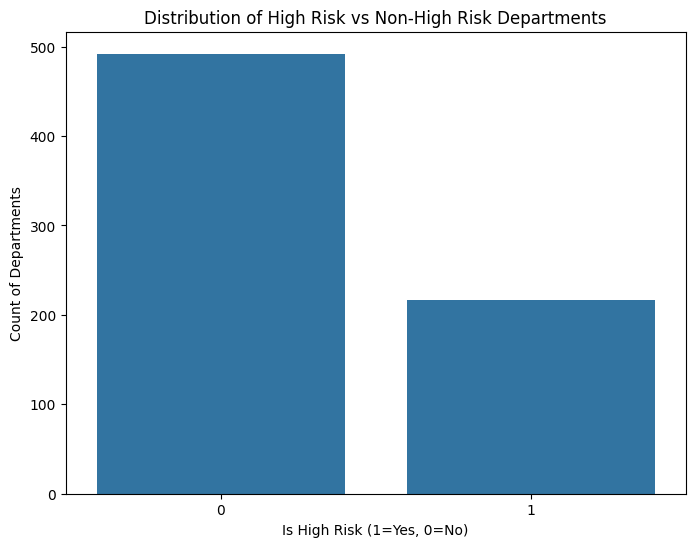

In [16]:
# Visualizing the distribution of high risk vs non-high risk departments
plt.figure(figsize=(8, 6))
sns.countplot(x='is_high_risk', data=departments_full)
plt.title('Distribution of High Risk vs Non-High Risk Departments')
plt.xlabel('Is High Risk (1=Yes, 0=No)')
plt.ylabel('Count of Departments')

# Save plot to visuals folder
plt.savefig(images_path + 'high_risk_department_distribution.png')


### Handling Missing Values

In [72]:
missing_summary = departments_full.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

digital_systems                    304
violations_past_3years             303
oversight_body                     303
interdept_collaboration_score      303
external_interactions_frequency    303
onboarding_program                 302
training_hours_quarterly           300
external_partnerships              300
overall_risk_score                 300
supervisor_experience_level        300
team_size                          300
engagement_programs                299
resource_availability_score        299
risk_exposure_financial            299
location_type                      299
dept_age_years                     298
operational_health_index           298
remediation_plan_active            298
reporting_lag_days                 297
reporting_gaps_annual              297
creation_reason                    297
dept_type                          296
manager_experience_level           296
reporting_structure                296
executive_support                  296
external_consulting      

##### Overall we have many missing values accross different columns of approximately 35% to 43%. 

C:\Users\Cesar Dushimimana\AppData\Local\Temp\ipykernel_29544\1173124081.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


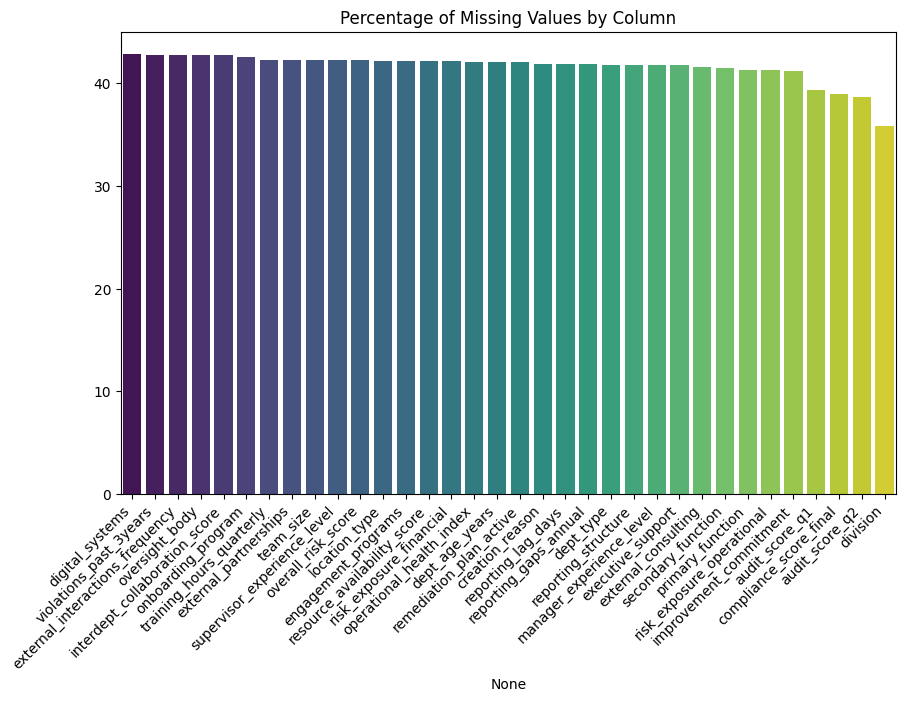

In [76]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
missing_percent = (departments_full.isnull().sum() / len(departments_full)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Missing Values by Column')

# Save Visuals to images folder
plt.savefig(images_path + 'missing_values_percentage.png')


#### Identifying Numerical and Categorical Columns

In [77]:
numerical_cols = departments_full.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = departments_full.select_dtypes(include=['object', 'category']).columns.tolist()


### Imputing Missing Values

#### A. Imputing Numeric Values

In [78]:
# Imputing numeric values 

num_imputer = SimpleImputer(strategy='median')
departments_full[numerical_cols] = num_imputer.fit_transform(departments_full[numerical_cols])


#### B. Imputing Categorical Values

In [79]:
# Imputing categorical values by filling with 'Unknown'

departments_full[categorical_cols] = departments_full[categorical_cols].fillna("Unknown")


In [80]:
# Checking that there are no more missing values

missing_summary = departments_full.isnull().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]


Series([], dtype: int64)

#### Saving CSV of Cleaned 'departments_full' Dataset

In [82]:
# Saving CSV of Cleaned 'departments_full' Dataset
departments_full.to_csv(processed_data_path + 'departments_full_cleaned.csv', index=False)

### Distribution Visualization & Handling Outliers 

##### A. Distributions of numerical columns, using subplots

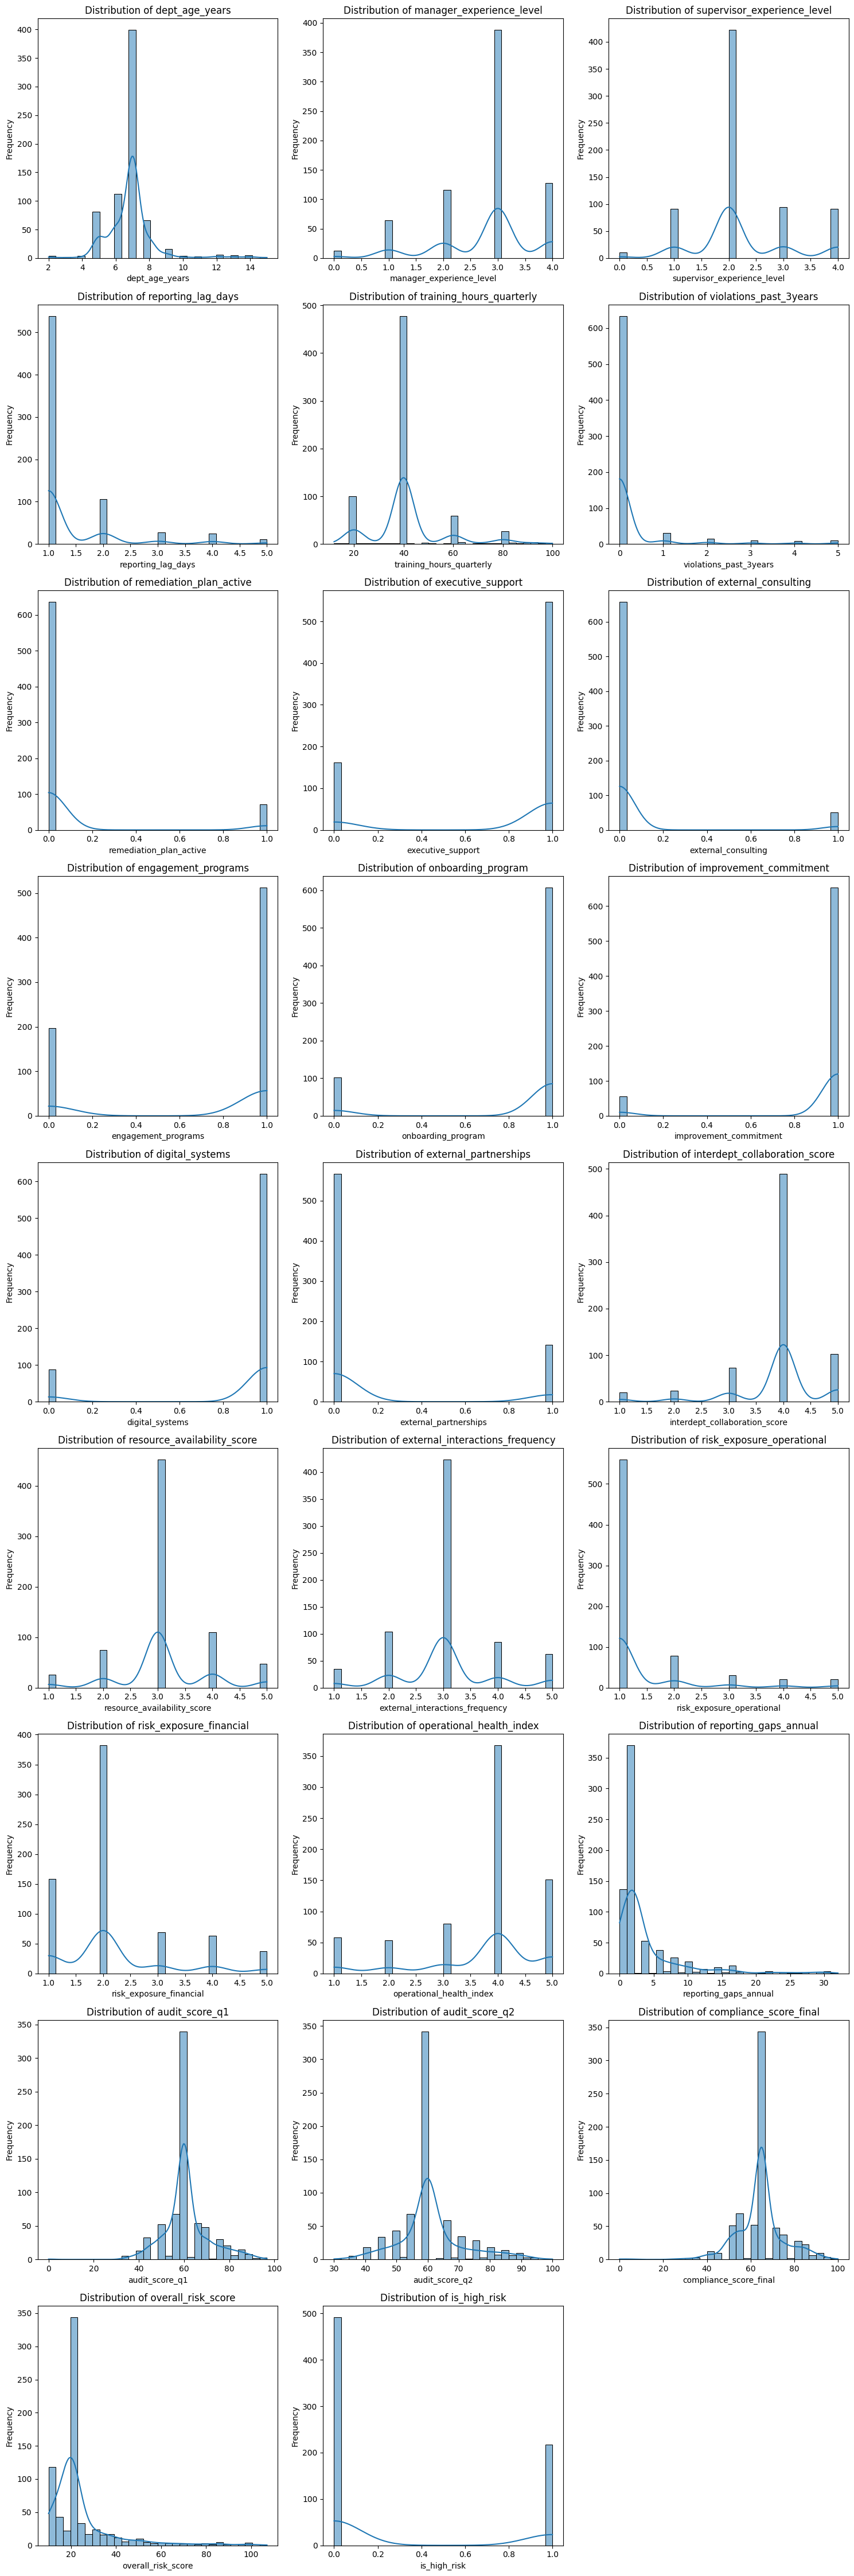

In [83]:
# Distributions of numerical columns, using subplots

num_plots = len(numerical_cols)
cols = 3
rows = (num_plots // cols) + int(num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

for i, col in enumerate(numerical_cols):
    sns.histplot(departments_full[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

# Save plot to images folder
plt.savefig(images_path + 'numerical_columns_distributions.png')



##### Comments on the Distributions

The dept_age_years distribution is tightly centered around 7 years, with only a small set of older departments beyond 10 years. manager_experience_level and supervisor_experience_level both follow a discrete ordinal pattern (0–4); we retain these as numeric during EDA to preserve ordering. reporting_lag_days is highly right-skewed, with most departments reporting quickly and a long tail of delays. training_hours_quarterly shows a sharp central spike, suggesting a common standard value, with smaller clusters at other levels. violations_past_3years is zero-inflated, with many departments having no violations and a long sparse tail for positive counts. Several operational and policy indicators — remediation_plan_active, executive_support, external_consulting, engagement_programs, onboarding_program, improvement_commitment, digital_systems, and external_partnerships — display near-binary or low-cardinality patterns, indicating boolean or ordinal behavior rather than continuous variation.

Scores such as interdept_collaboration_score, resource_availability_score, and external_interactions_frequency show clear discrete peaks consistent with ordinal rating scales. risk_exposure_operational displays a heavy concentration at lower values with a thin tail, while risk_exposure_financial spreads more broadly across its scale with multiple local peaks. operational_health_index is concentrated toward high values but retains variation across the scale. reporting_gaps_annual is notably right-skewed with few large-gap outliers. audit_score_q1, audit_score_q2, and compliance_score_final show roughly symmetric, bell-like distributions with pronounced central modes, which may reflect standardized scoring. overall_risk_score again exhibits right skew, with most departments at low risk and fewer at higher values. Finally, is_high_risk shows the expected binary split, acting as the target label for classification.

#### Handling Outliers

##### 1. Visualizing Numeric Features by Boxplot: Detecting Outliers

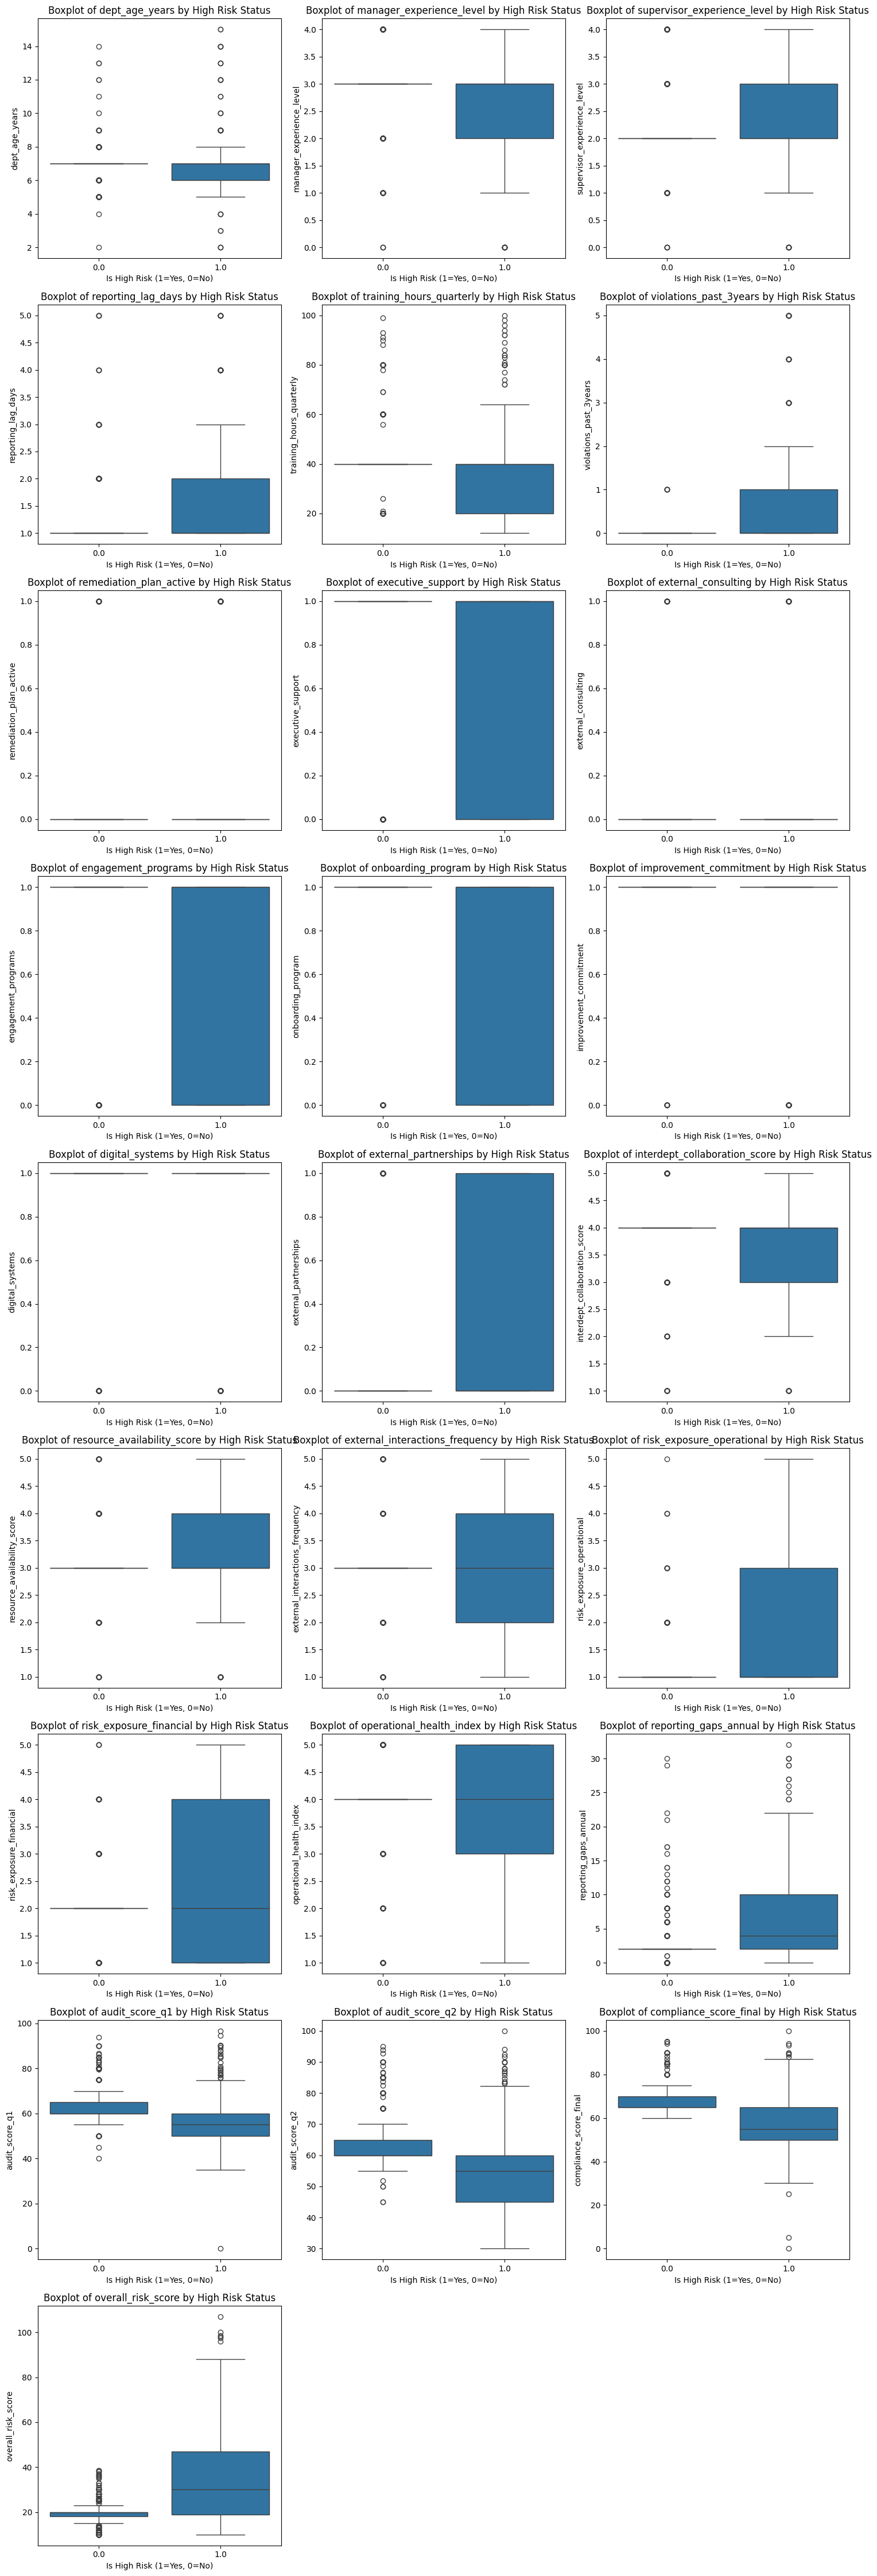

In [84]:
# identify numerical columns for boxplots, without the target variable
numeric_cols = departments_full.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('is_high_risk')  # Exclude target variable

# Boxplots of numerical columns grouped by 'is_high_risk'
num_plots = len(numeric_cols)
cols = 3
rows = (num_plots // cols) + int(num_plots % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x='is_high_risk', y=col, data=departments_full, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by High Risk Status')
    axes[i].set_xlabel('Is High Risk (1=Yes, 0=No)')
    axes[i].set_ylabel(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

# Save plot to images folder
plt.savefig(images_path + 'numerical_columns_boxplots.png')

The boxplots reveal clear outliers across several numeric features. Reporting_lag_days, training_hours_quarterly, violations_past_3years, reporting_gaps_annual, and overall_risk_score show strong right-tail outliers, indicating a minority of departments with unusually high delays, training hours, violations, or risk levels. Audit_score_q1, audit_score_q2, and compliance_score_final also contain low-value outliers among high-risk groups, suggesting under-performing departments. Operational and financial risk scores show dispersed outliers mainly in high-risk departments. Binary or near-binary operational indicators (e.g., onboarding_program, digital_systems, executive_support) show no meaningful outliers due to limited value ranges. Overall, the outliers correspond to departments exhibiting extreme behavior in reporting delays, violations, and audit performance—key variables that align with high-risk classifications.

#### Compliance score distribution

Compliance and audit scores (Q1 and Q2) are approximately centered around their mid-range values with moderate spread, while the overall risk score is strongly right-skewed, indicating that most departments exhibit low risk with a smaller number of high-risk outliers.

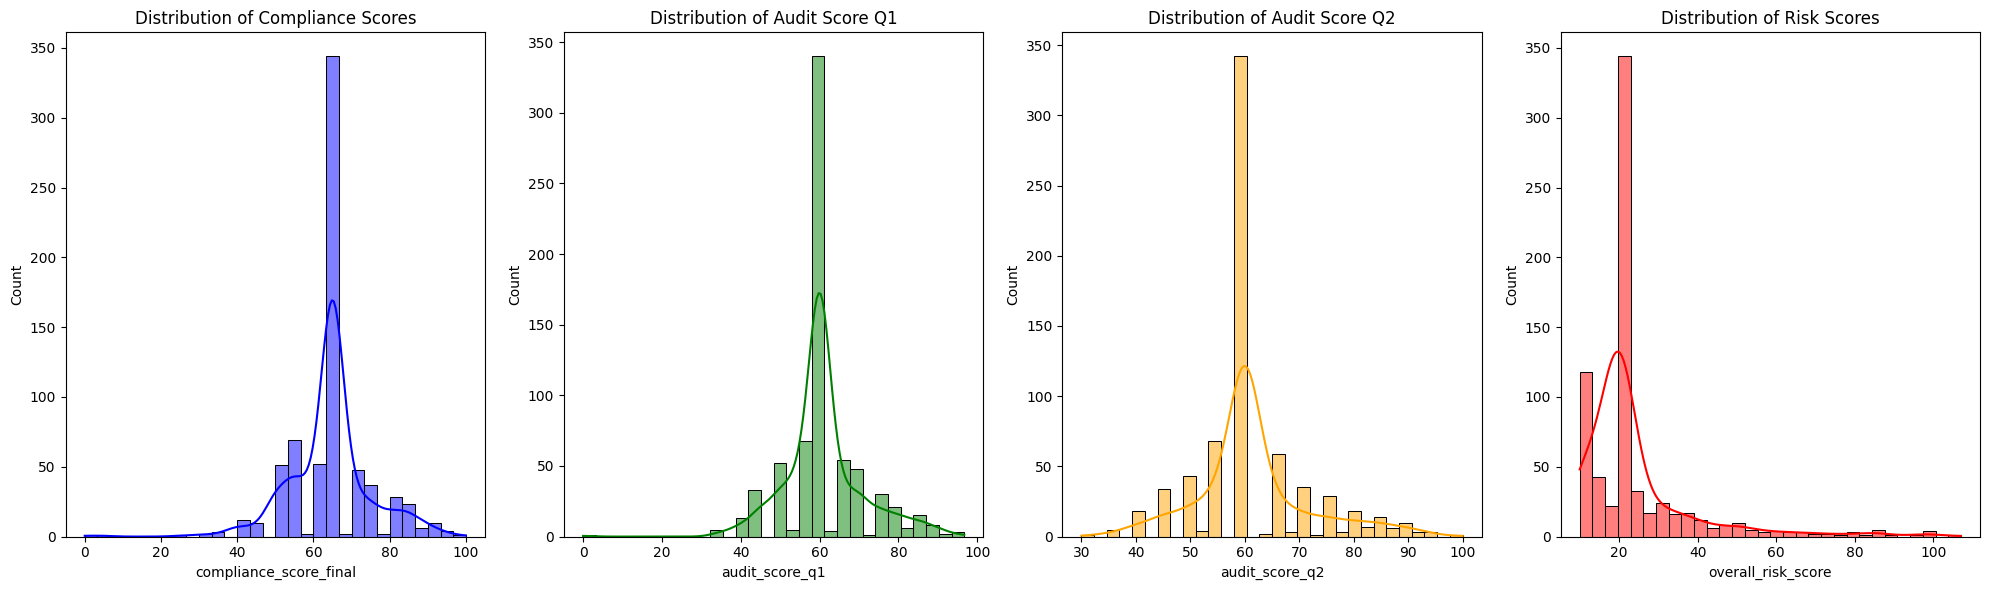

In [86]:
# Subplot of Compliance score distribution, audit_score_q1	audit_score_q2 and risk scores
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
sns.histplot(departments_full['compliance_score_final'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Compliance Scores')
sns.histplot(departments_full['audit_score_q1'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Audit Score Q1')
sns.histplot(departments_full['audit_score_q2'], bins=30, kde=True, ax=axes[2], color='orange')
axes[2].set_title('Distribution of Audit Score Q2')
sns.histplot(departments_full['overall_risk_score'], bins=30, kde=True, ax=axes[3], color='red')
axes[3].set_title('Distribution of Risk Scores')

plt.tight_layout()
# Save plot to images folder
plt.savefig(images_path + 'compliance_audit_risk_scores_distribution.png')
plt.show()



#### Correlations between compliance score, risk score, and other numeric features

The correlation matrix shows that is_high_risk is most strongly and positively correlated with risk-intensive indicators, particularly overall_risk_score, violations_past_3years, risk_exposure_operational, and risk_exposure_financial. This confirms that departments with a history of violations and higher exposure levels are substantially more likely to be classified as high-risk.

In contrast, audit and compliance performance variables—including compliance_score_final, audit_score_q1, and audit_score_q2 have moderate negative correlations with is_high_risk. This indicates that stronger audit outcomes and higher compliance scores are associated with a lower probability of being flagged as high-risk. 

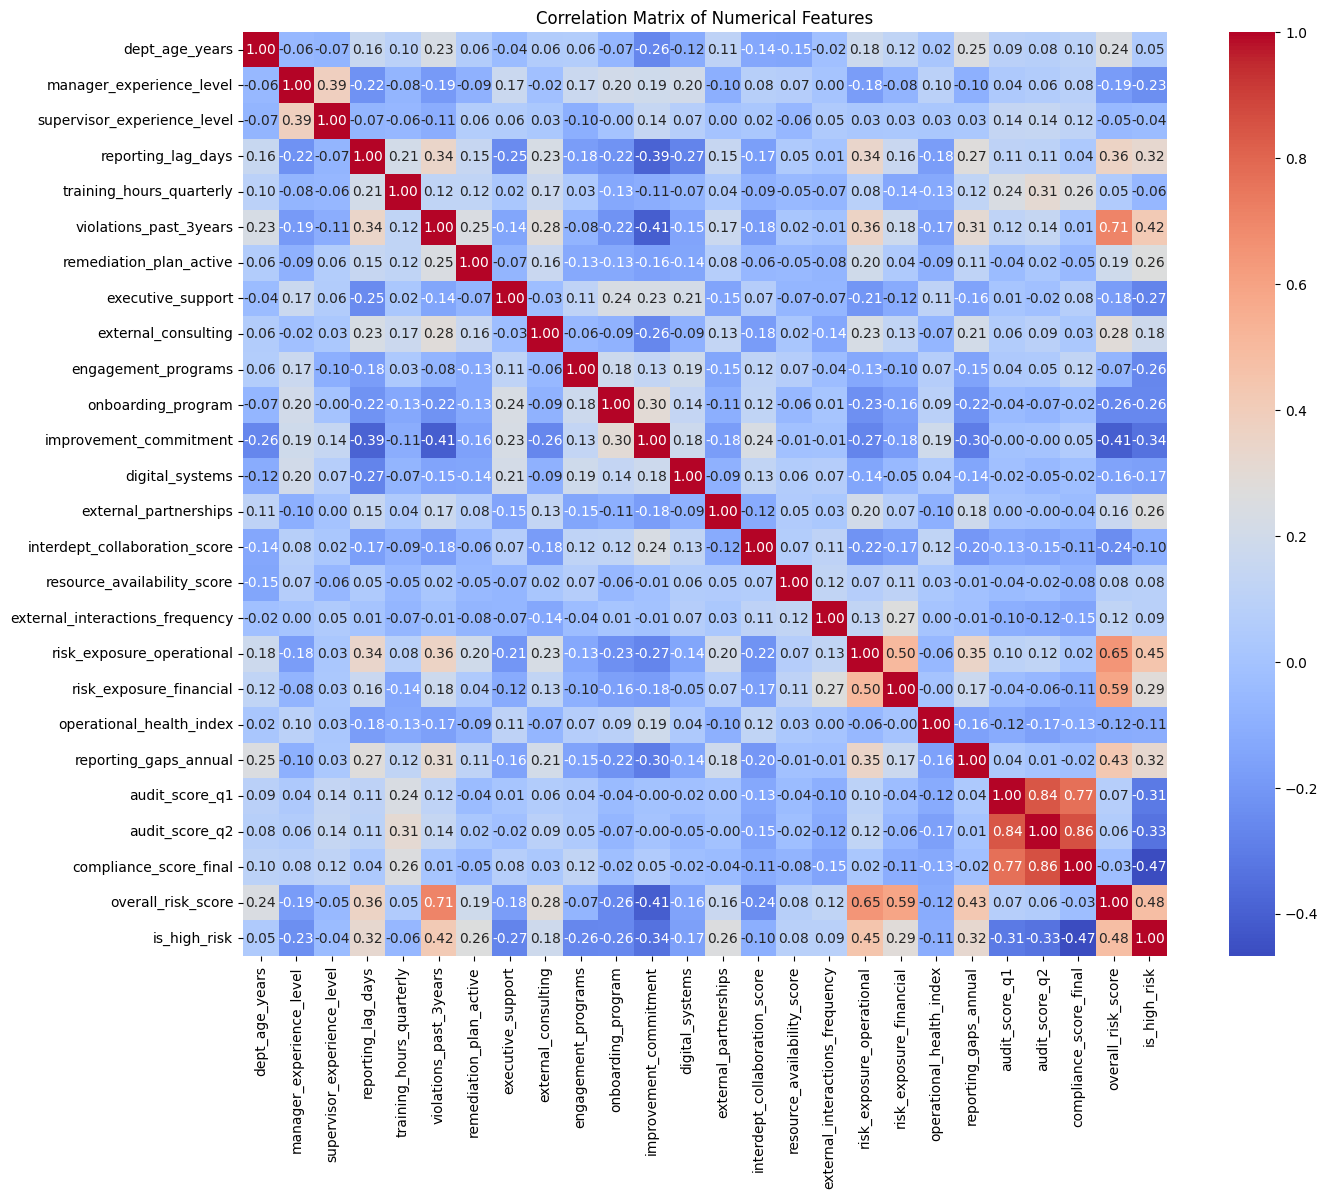

In [87]:
# Checking correlations between compliance score, risk score, and other only numerical features

numeric_cols = departments_full.select_dtypes(include=[np.number]).columns.tolist()

# Creating and saving correlation matrix heatmap to images folder
corr_matrix = departments_full[numeric_cols].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.savefig(images_path + 'correlation_matrix_numerical_features.png')
plt.show()
plt.close()





####  Divisions with highest average compliance scores

In [35]:
# reading risk_by_division from processed data folder
risk_by_division = pd.read_csv(raw_data_path + 'risk_summary_by_division.csv')
risk_by_division.head()

,division,avg_compliance_score,std_compliance_score,min_compliance_score,max_compliance_score,total_violations,avg_risk_score,dept_count
0,Corporate_HQ,63.245477,13.369017,0.0,95.0,122.0,24.463636,428
1,Regional_Operations,76.054167,13.777896,50.8,100.0,55.0,64.000000,27


Regional operations department shows the highest average compliance score amongest all divisiones

#### Formatting Column Values as Per Dictionary Description

In [89]:
# Selecting boolean-like columns for analysis

bool_cols = [
    'remediation_plan_active',
    'executive_support',
    'external_consulting',
    'engagement_programs',
    'onboarding_program',
    'improvement_commitment',
    'digital_systems',
    'external_partnerships'
]


#### Converting Boolean-Like Columns to Boolean

During preprocessing, several features in the dataset were identified as binary-like indicators (e.g., `onboarding_program`, `remediation_plan_active`, `digital_systems`). Since these variables represent the presence or absence of a departmental characteristic rather than a numeric quantity, they were converted to boolean (`True/False`) whenever the column contained strictly 0/1 values. This preserves the semantic meaning of the feature, prevents accidental scaling during model preprocessing, and ensures proper handling by encoders such as `OneHotEncoder`. Columns that resembled binary variables but contained additional values were instead converted to categorical variables. This approach maintains data integrity and supports clearer modeling and interpretation.


In [91]:
# Checking data types of boolean-like columns as per dictionary descrpiptios
departments_full[bool_cols].dtypes

remediation_plan_active    float64
executive_support          float64
external_consulting        float64
engagement_programs        float64
onboarding_program         float64
improvement_commitment     float64
digital_systems            float64
external_partnerships      float64
dtype: object

In [92]:
for col in bool_cols:
    vals = departments_full[col].dropna().unique()
    
    # convert (0,1) to boolean
    if set(vals).issubset({0, 1}):
        departments_full[col] = departments_full[col].astype(bool)
    else:
        # Otherwise treat as category
        departments_full[col] = departments_full[col].astype('category')


In [93]:
# Checking if conversion was successful
departments_full[bool_cols].dtypes

remediation_plan_active    bool
executive_support          bool
external_consulting        bool
engagement_programs        bool
onboarding_program         bool
improvement_commitment     bool
digital_systems            bool
external_partnerships      bool
dtype: object

#### Visualizing Categorical-Boolean Columns Against Risk Status 

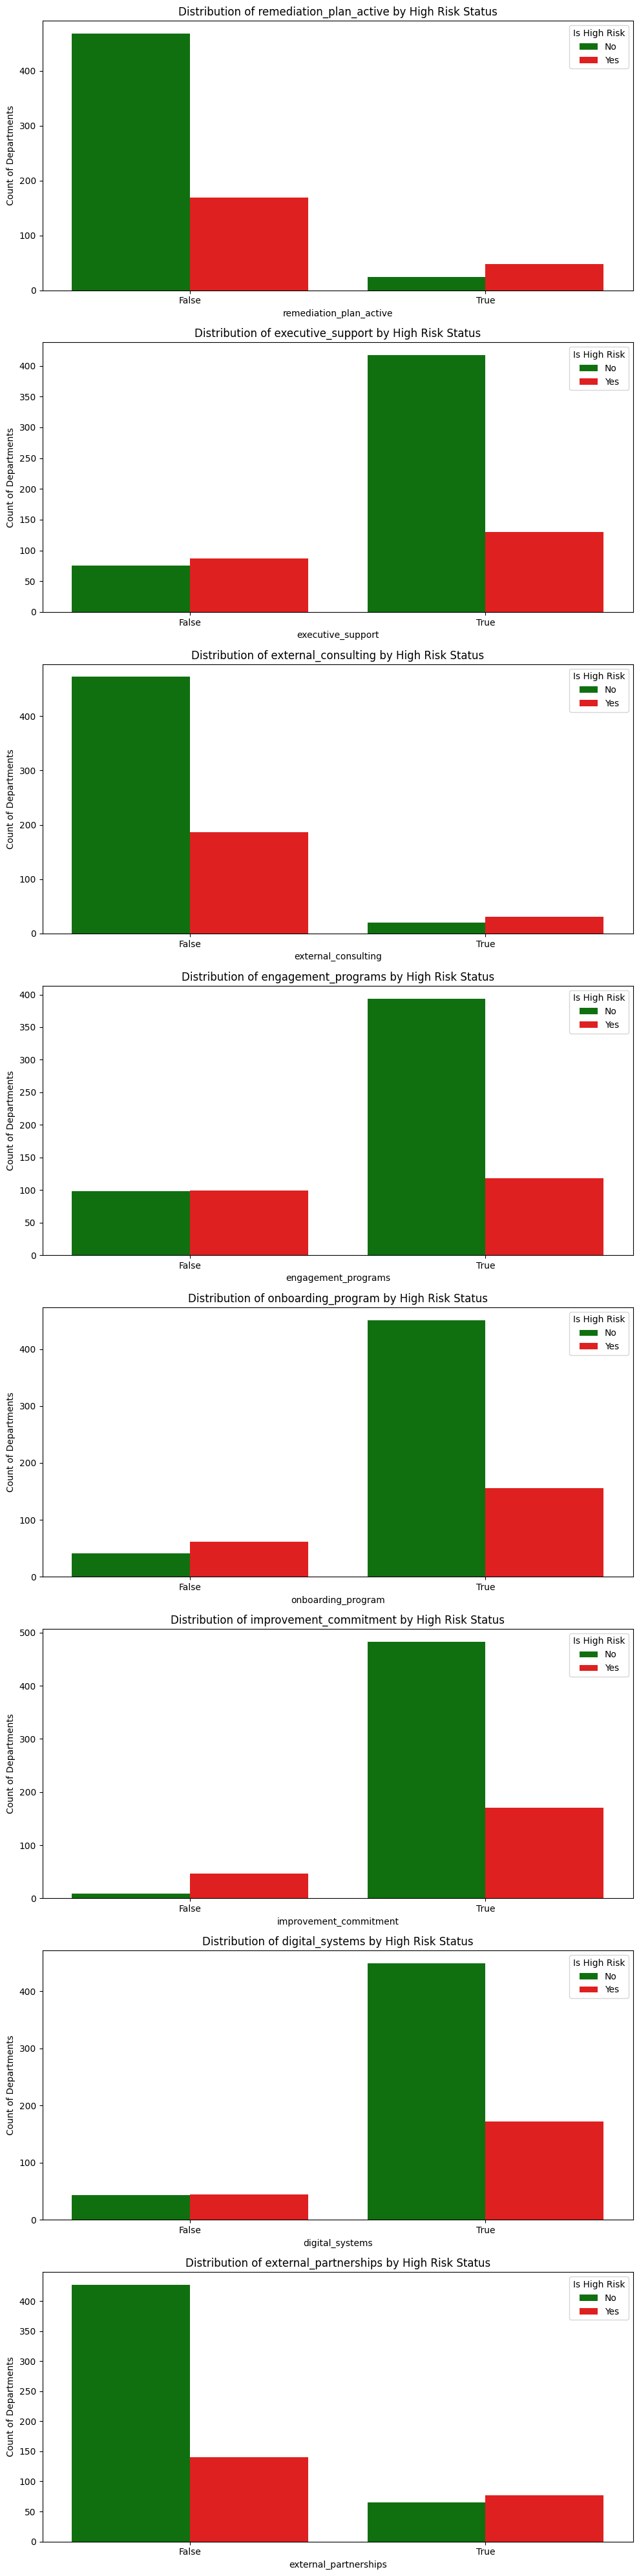

In [95]:
# Visualizing distributions of boolean columnns with is_high_risk hue (using subplots)

fig, axes = plt.subplots(len(bool_cols), 1, figsize=(10, 5 * len(bool_cols)))
for i, col in enumerate(bool_cols):
    sns.countplot(x=col, hue='is_high_risk', data=departments_full, ax=axes[i], palette={0: 'green', 1: 'red'})
    axes[i].set_title(f'Distribution of {col} by High Risk Status')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count of Departments')
    axes[i].legend(title='Is High Risk', labels=['No', 'Yes'])

# Save plot to images folder
plt.savefig(images_path + 'boolean_columns_distributions_by_high_risk.png')
    
plt.tight_layout()
plt.show()

#### Handling Numeric-Ordinal Columns

**The ordinal rating features** were preserved as integer-encoded ordered variables (rather than one-hot encoded) to retain their inherent ranking and allow models to learn risk relationships.

In [41]:
ordinal_cols = [
    'interdept_collaboration_score',
    'resource_availability_score',
    'external_interactions_frequency',
    'risk_exposure_operational',
    'risk_exposure_financial',
    'operational_health_index'
]

departments_full[ordinal_cols].dtypes



interdept_collaboration_score      float64
resource_availability_score        float64
external_interactions_frequency    float64
risk_exposure_operational          float64
risk_exposure_financial            float64
operational_health_index           float64
dtype: object

In [96]:
# Other ordinal columns to check
ordinal_col1 = [
    'manager_experience_level',
    'supervisor_experience_level'
]

departments_full[ordinal_col1].describe()

,manager_experience_level,supervisor_experience_level
count,709.000000,709.000000
mean,2.781382,2.229901
std,0.907528,0.885800
min,0.000000,0.000000
25%,2.000000,2.000000
50%,3.000000,2.000000
75%,3.000000,3.000000
max,4.000000,4.000000


Keep them as integers (0–4) to preserve the natural ordering.

#### Reporting_gaps_annual distribution by high risk status

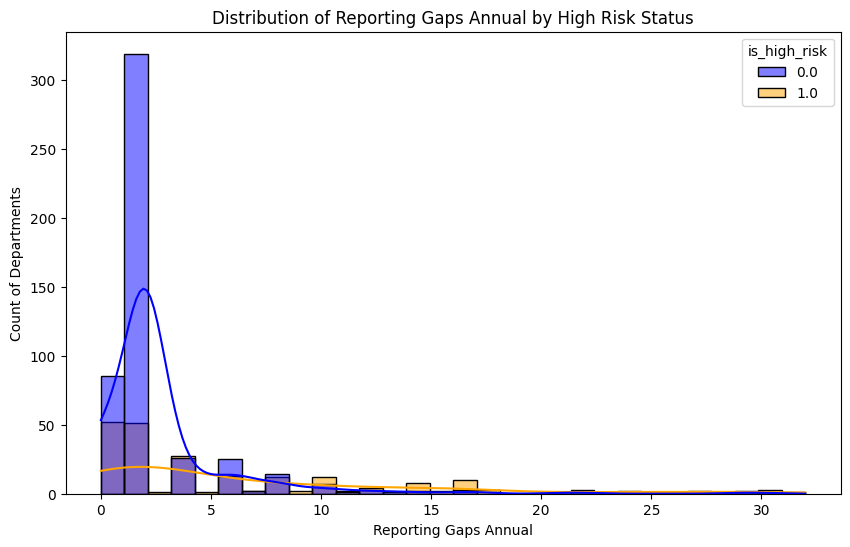

In [46]:

# Plotting reporting_gaps_annual distribution by high risk status (best plot for this case)
plt.figure(figsize=(10, 6))
sns.histplot(data=departments_full, x='reporting_gaps_annual', hue='is_high_risk', bins=30, kde=True, palette={0: 'blue', 1: 'orange'})
plt.title('Distribution of Reporting Gaps Annual by High Risk Status')
plt.xlabel('Reporting Gaps Annual')
plt.ylabel('Count of Departments')

# Save plot to images folder
plt.savefig(images_path + 'reporting_gaps_annual_by_high_risk_status.png')
plt.show()

When the reporting_gaps_annual is higher, the department is more likely to be high risk. From the plot above, we can see that departments with higher reporting gaps annual tend to have a higher count of high risk status (is_high_risk = 1). This suggests a positive correlation between reporting gaps and the likelihood of being classified as high risk. Specifically, from around 10 annual reporting gaps and above, there is a noticeable increase in the number of high risk departments compared to non-high risk ones. This indicates that departments with more frequent reporting gaps may face greater compliance challenges, leading to a higher risk classification.

#### One-Hot Encoding Categorical Columns

##### Converting string columns to categorical
Several features in the dataset, such as primary_function, secondary_function, creation_reason, and oversight_body, are nominal categorical variables represented as strings. These variables do not contain any natural ordering, so they will be converted using One-Hot Encoding during preprocessing. 

In [97]:
# Converting string columns to categorical data type and converting 'UKNOWN' to NaN for missing values
string_cols = [
    'primary_function',
    'secondary_function',
    'creation_reason',
    'oversight_body'
]

for col in string_cols:
    departments_full[col] = departments_full[col].replace('UNKNOWN', np.nan).astype('category')

# Check that conversion was successful
departments_full[string_cols].dtypes


primary_function      category
secondary_function    category
creation_reason       category
oversight_body        category
dtype: object

#### Encoding Categorical Columns

In [98]:
# Identifying categorical columns
categorical_cols = departments_full.select_dtypes(include=['category']).columns.tolist()

# Creating imputer for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fitting and transforming categorical columns
departments_full[categorical_cols] = cat_imputer.fit_transform(departments_full[categorical_cols])

In [99]:
# One-hot encoding categorical variables
departments_full = pd.get_dummies(
    departments_full,
    columns=categorical_cols,
    drop_first=False
)



Since we had a single dataset for building and evaluating the models in this project, categorical variables were preprocessed directly within the DataFrame before splitting.

In [104]:
# Converting other categorical columns to categorical data type

other_cat_cols = [
    'dept_category',
    'division',
    'dept_type',
    'location_type',
    'team_size',
    'reporting_structure'
]


# Converting other_cat_cols to categorical data type
for col in other_cat_cols:
    departments_full[col] = departments_full[col].astype('category')

departments_full[other_cat_cols].dtypes

dept_category          category
division               category
dept_type              category
location_type          category
team_size              category
reporting_structure    category
dtype: object

In [105]:
# Replacing 'UNKNOWN' with NaN in other_cat_cols
for col in other_cat_cols:
    departments_full[col] = departments_full[col].replace('UNKNOWN', np.nan)


# Impute with most frequent category
cat_imputer = SimpleImputer(strategy='most_frequent')
# Fitting and transforming categorical columns
departments_full[other_cat_cols] = cat_imputer.fit_transform(departments_full[other_cat_cols])


In [106]:
# applying one-hot encoding to other_cat_cols
departments_full = pd.get_dummies(
    departments_full,
    columns=other_cat_cols,
    drop_first=False
)


The remaining nominal categorical variables (dept_category, division, dept_type, location_type, team_size, and reporting_structure) were processed consistently with the prior encoding steps. 

### Dataset Splitting (Train/Test Split) and Building ML Model

Final clean dataset is saved under the processed_data_path in the data folder of this project. 

In [107]:
# Remove unnecessary columns that won't be used for modeling
departments_full = departments_full.drop(['dept_id', 'dept_name'], axis=1)

# Save final cleaned and preprocessed dataset for modeling
departments_full.to_csv(processed_data_path + 'data_final_clean.csv', index=False)


In [108]:
# Reading final cleaned data for modeling
data_clean = pd.read_csv(processed_data_path + 'data_final_clean.csv')

##### Splitting the Dataset
Splitting data into features and target variable, with stratification because of the is_high_risk target variable imbalance

In [109]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = data_clean.drop('is_high_risk', axis=1)
y = data_clean['is_high_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


##### Scaling Numerical Variables
Standardizing numerical features to avoid scale-related biases while modeling

In [111]:
from sklearn.preprocessing import StandardScaler

num_cols = X_train.select_dtypes(include=['int64','float64']).columns

# Standardizing numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


#### Building and Evaluating ML Models

In this compliance problem the model must be explainable and able to capture nonlinearity nature of this dataset. As part of the problem, we need to understand which factors drive high-risk predictions beyond just classifying the departments. Therefore, a model that weighs on the interpretability and performance is a good fit.

##### 1. Logistic Regression

In [148]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # help with imbalanced target variable
    random_state=64
)

log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]


##### 1.a Evaluating Logistic Regression Model

The Logistic Regression model performs well for compliance risk detection, achieving a high recall of 0.93 for high-risk departments, which is crucial to minimize missed risks. While this comes with some false positives (precision = 0.77), this trade-off is acceptable in a compliance context where flagging potential risk is safer than overlooking it. The strong ROC-AUC score of 0.93 confirms that the model effectively separates high-risk from non-high-risk departments.

In [149]:
# Importing evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not High Risk', 'High Risk']))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.3f}")

Confusion Matrix:
 [[87 12]
 [ 3 40]]

Classification Report:
               precision    recall  f1-score   support

Not High Risk       0.97      0.88      0.92        99
    High Risk       0.77      0.93      0.84        43

     accuracy                           0.89       142
    macro avg       0.87      0.90      0.88       142
 weighted avg       0.91      0.89      0.90       142

ROC-AUC Score: 0.933


##### 1.b Confusion Matrix for Logistic Regression

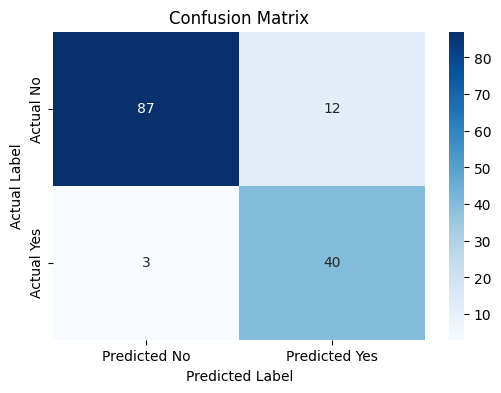

In [150]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix with heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# Save plot to images folder
plt.savefig(images_path + 'confusion_matrix_logistic_regression.png')
plt.show()

##### 1.c ROC Curve

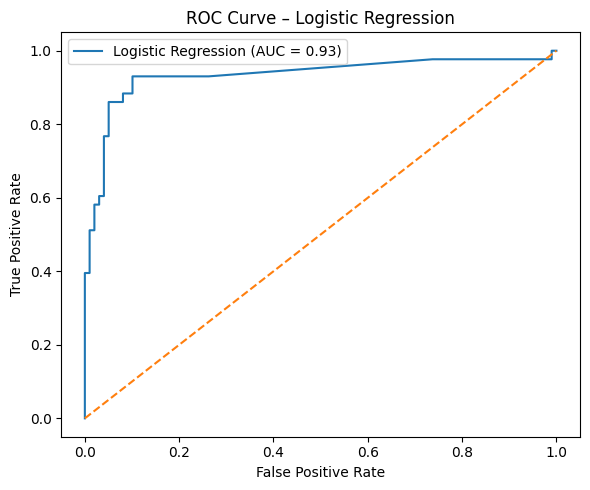

In [151]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend()
plt.tight_layout()
# Save plot to images folder
plt.savefig(images_path + 'roc_curve_logistic_regression.png')
plt.show()


##### 1.d Understanding Coefficients Importance & High Risk Drivers

C:\Users\Cesar Dushimimana\AppData\Local\Temp\ipykernel_29544\693276351.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='abs_impact', y='feature', data=top_10_features, palette='viridis')


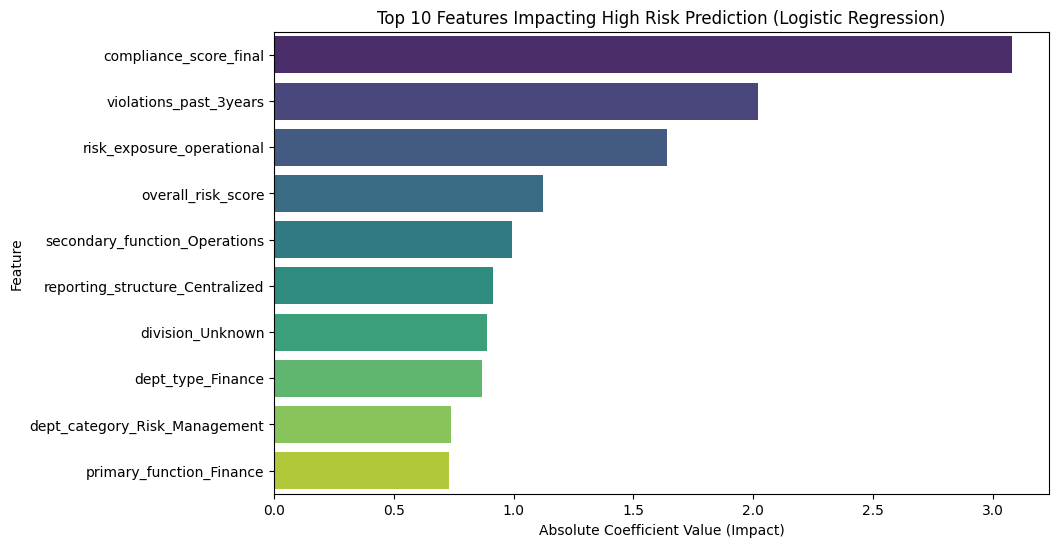

In [157]:

# Extract coefficients
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': log_reg.coef_[0]
})

# Add absolute impact for ranking, i.e., absolute value of coefficients
coef_df['abs_impact'] = coef_df['coefficient'].abs()

# determining the direction of impact 
coef_df['direction'] = coef_df['coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Rank by absolute impact
coef_df = coef_df.sort_values(by='abs_impact', ascending=False)

# saving coefficients to CSV
coef_df.to_csv(reports_path + 'logistic_regression_feature_importance.csv', index=False)

# Top 10 impactful features on high risk prediction
top_10_features = coef_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='abs_impact', y='feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Features Impacting High Risk Prediction (Logistic Regression)')   
plt.xlabel('Absolute Coefficient Value (Impact)')
plt.ylabel('Feature')
# Save plot to images folder
plt.savefig(images_path + 'top_10_features_logistic_regression.png')
plt.show()

In [161]:
# Saving top 5 increasing and top 5 decreasing features of high risk prediction to CSV
top_5_increasing = coef_df[coef_df['direction'] == 'Positive'].head(5)
top_5_descreaing = coef_df[coef_df['direction'] == 'Negative'].head(5)

# Save to reports folder
top_5_increasing.to_csv(reports_path + 'top_5_increasing_features_logistic_regression.csv', index=False)
top_5_descreaing.to_csv(reports_path + 'top_5_decreasing_features_logistic_regression.csv', index=False)

#### Building Random Forest Model

In [186]:
# Building random forest model for comparison
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=15, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)



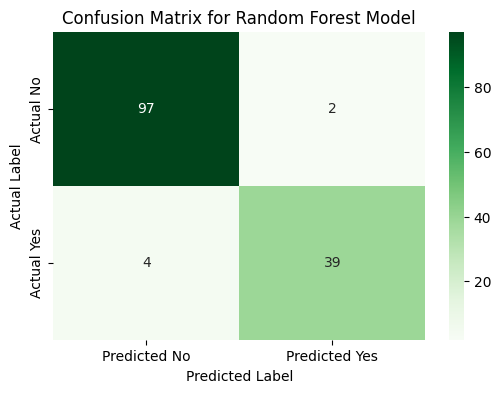

In [187]:
# Confusion Matrix for Random Forest Model
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
# Save plot to images folder
plt.savefig(images_path + 'confusion_matrix_random_forest.png')
plt.show()

In [188]:
# Evaluating random forest model performance

print("\nClassification Report for Random Forest Model:")
print(classification_report(y_test, y_pred_rf, target_names=['Not High Risk', 'High Risk']))



Classification Report for Random Forest Model:
               precision    recall  f1-score   support

Not High Risk       0.96      0.98      0.97        99
    High Risk       0.95      0.91      0.93        43

     accuracy                           0.96       142
    macro avg       0.96      0.94      0.95       142
 weighted avg       0.96      0.96      0.96       142



In [189]:
# Comparing the two models based on F1-score and ROC-AUC
from sklearn.metrics import f1_score, roc_auc_score
f1_log_reg = f1_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"\nF1-Score Comparison:\nLogistic Regression: {f1_log_reg:.3f}\nRandom Forest: {f1_rf:.3f}")
print(f"\nROC-AUC Comparison:\nLogistic Regression: {roc_auc_log_reg:.3f}\nRandom Forest: {roc_auc_rf:.3f}")




F1-Score Comparison:
Logistic Regression: 0.842
Random Forest: 0.929

ROC-AUC Comparison:
Logistic Regression: 0.933
Random Forest: 0.964


It is clear that random forest performs better with higher F1-Score. However, when feauture interpretation is necessary logistic regression would still be useful. 